In [0]:
import numpy as np
from scipy import stats

def posterior(Phi, t, alpha, beta):
  S_N_inv = alpha * np.eye(Phi.shape[1]) + beta * Phi.T.dot(Phi)
  S_N = np.linalg.inv(S_N_inv) #slide 10, bayes regression
  m_N = beta * S_N.dot(Phi.T).dot(t)
  return m_N, S_N


def posterior_prediction(Phi_test, m_N, S_N, beta):
  y = Phi_test.dot(m_N)
  y_var = 1/beta + np.sum(Phi_test.dot(S_N) * Phi_test, axis=1)
  return y, y_var

f_w0 = 0
f_w1 = 0.5

def f(X, noise_variance):
  return f_w0 + f_w1 * X + noise(X.shape, noise_variance)

def g(X, noise_variance):
  return 0.5 + np.sin(2*np.pi*X) + noise(X.shape, noise_variance)

def noise(size, variance):
  return np.random.normal(scale=np.sqrt(variance), size=size)

def identity_basis_function(x):
  return x

def expand(x, bf):
  return np.concatenate([np.ones(x.shape), bf(x)], axis=1)

def plot_posterior(mean, cov, w0, w1):
  resolution = 100
  grid_x = grid_y = np.linspace(-1, 1, resolution)
  grid_flat = np.dstack(np.meshgrid(grid_x, grid_y)).reshape(-1, 2)

  densities = stats.multivariate_normal.pdf(grid_flat, mean=mean.ravel(),
                                            cov=cov).reshape(resolution, resolution)

  plt.imshow(densities, origin='lower', extent=(-1, 1, -1, 1))
  plt.xlabel('w0')
  plt.ylabel('w1')


def plot_posterior_samples(x, ys, plot_xy_labels=True):
  plt.plot(x, ys[:, 0], 'r-', alpha=0.5, label='posterior samples')
  for i in range(1, ys.shape[1]):
    plt.plot(x, ys[:, i], 'r-', alpha=0.5)


def plot_predictive(x, y, std):
  y = y.ravel()
  plt.plot(x, y)
  plt.fill_between(x.ravel(), y+std, y-std, alpha=0.5)

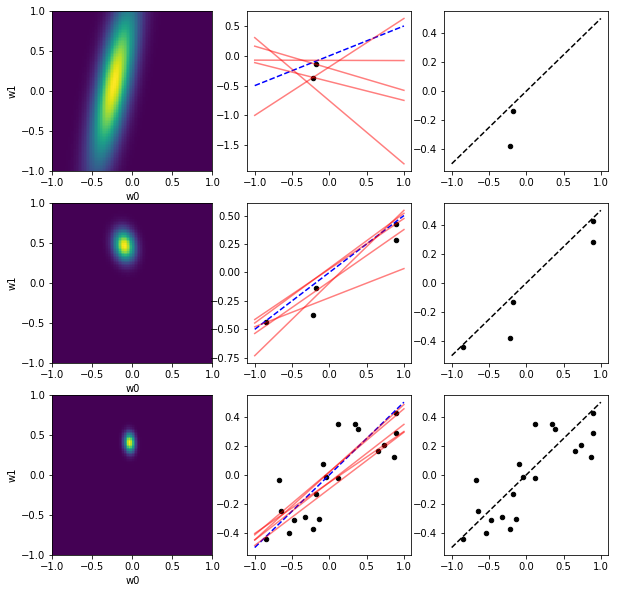

In [41]:
import matplotlib.pyplot as plt


#training set data sizes
N_list = [2, 5, 20]
alpha = 2.0
beta = 25.0

#training observations
X = np.random.rand(N_list[-1], 1) * 2 - 1

#compute target values for training
t = f(X, 1/beta)

#test observation
X_test = np.linspace(-1, 1, 100).reshape(-1, 1)

#function values without noise
y_true = f(X_test, noise_variance=0)

#design matrix of test observations
Phi_test = expand(X_test, identity_basis_function)

plt.figure(figsize=(10,10))

for i, N in enumerate(N_list):
  X_N = X[:N]
  t_N = t[:N]

  #design matrix of training observations
  Phi_N = expand(X_N, identity_basis_function)

  #mean and covariance of posterior
  m_N, S_N = posterior(Phi_N, t_N, alpha, beta)

  #mean and covariance of posterior predictive
  y, y_var = posterior_prediction(Phi_test, m_N, S_N, beta)

  #draw 5 random weight samples from posterior and compute y values
  w_samples = np.random.multivariate_normal(m_N.ravel(), S_N, 5).T
  y_samples = Phi_test.dot(w_samples)

  #plot the posterior
  plt.subplot(len(N_list), 3, i*3+1)
  plot_posterior(m_N, S_N, f_w0, f_w1)

  plt.subplot(len(N_list), 3, i*3+2)
  plt.scatter(X_N, t_N, marker='o', c='k', s=20)
  plt.plot(X_test, y_true, 'b--', label='Truth')
  plot_posterior_samples(X_test, y_samples)

  plt.subplot(len(N_list), 3, i*3+3)
  plt.scatter(X_N, t_N, marker='o', c='k', s=20)
  plt.plot(X_test, y_true, 'k--')